In [3]:
'''
Script to generate plots from paper for Part II
'''

import numpy as np
import pandas as pd
import json 
import os
import sys
import random
import math
import matplotlib.pylab as plt 
import seaborn as sns
import scipy.stats as stats
from matplotlib.font_manager import FontProperties
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
import itertools
import matplotlib

In [4]:
def parse_rating(rating_str): 
    # cognition.run saves all data as strings
    # need to parse dictionary from a string
    # returns an int
    rating = rating_str.split(":")[-1].split("}")[0]
    return int(rating)

import os
save_dir = "./final_plots/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
sources = ["human", "gpt-3"]
constraints = ['unconstrained', 'constrained_single', 'constrained_many']
constraints_exps = ['unconstrained', 'single-constraint', 'all-constraints']

In [5]:
# planning data 
data_pth = "/Users/kcollins/language_and_structure_of_thoughts/plans/exp_results/group-a-mixed-group-b-rate-overall-goodness-of-plans-final.csv"

df = pd.read_csv(data_pth)
# remove any runs w/o PIDs (incomplete)
df = df.dropna(0, subset=["PROLIFIC_PID", "prompt"])

# filter out problem saves
df = df[(df.PROLIFIC_PID != '2021-10-13 17:10:06') &
       (df.PROLIFIC_PID != '2021-10-13 17:14:36')&
       (df.PROLIFIC_PID != '"')&
       (df.PROLIFIC_PID != '2021-10-14 12:31:35')&
       (df.PROLIFIC_PID!='2021-10-14 17:20:39')&
       (df.PROLIFIC_PID != '2021-10-14 19:06:42')&
       (df.PROLIFIC_PID != '2021-10-14 18:48:45')&
       (df.PROLIFIC_PID != '2021-10-15 14:46:26')].reset_index()

# extract subj ids
all_subjs = set(df.PROLIFIC_PID)

print("Num subjs: ", len(all_subjs), ", Num rows: ", len(df))
df.head(3)

# filter out to only include the ratings
# e.g., any response that was of type "rate_goodness" 
rating_df = df[(df.task == "rate_goodness")].reset_index()
# gather all goals
all_goals = set(rating_df.prompt)
print("Num goals: ", len(all_goals), " rating df: ", len(rating_df))
# keep only the first rating for people who saw a duplicate plan (due to accidental repeated planner)
for subj_id in all_subjs:
    subj_df = rating_df[rating_df.PROLIFIC_PID == subj_id]
    rated_plans = set()
    for idx, plan in zip(subj_df.index, subj_df.plan): 
        if plan in rated_plans: rating_df = rating_df.drop(idx)
        else: rated_plans.add(plan)
rating_df.columns

# get summary scores for each explanation 
grouped_data = {}
num_generations = {source: 0 for source in sources}
stimuli_per_cond = {constraint: [] for constraint in constraints}
data_per_goal = {source: {} for source in sources}

for source in sources: 
    source_rating_data = {constraint: [] for constraint in constraints}
    df_subset = rating_df[rating_df.subj_id == source]
    goal_rating_data = {}
    for constraint in constraints:
        constraint_df = df_subset[df_subset.goal_type == constraint]
        
        if len(stimuli_per_cond[constraint]) == 0: stimuli_per_cond[constraint] = sorted(set(constraint_df.prompt))
            
        generations = set(constraint_df["plan"])
        num_generations[source] += len(generations)
        for generation in generations: 
            generation_df = constraint_df[constraint_df.plan == generation]
            prompt = list(generation_df.prompt)[0] # same prompt for all generations, so just take the first
            ratings = [json.loads(rating_str)['goodness'] + 1 for rating_str in generation_df.response]
            avg_goodness = np.mean(ratings)
            median_goodness = np.median(ratings)
            
            obj = {'generation': generation, 'stimuli': prompt, 'mean': avg_goodness, 'median': median_goodness, 'ratings': ratings,
                  "constraint":constraint}
            
            source_rating_data[constraint].append(obj)
            if prompt not in data_per_goal[source]: data_per_goal[source][prompt] = [obj]
            else: data_per_goal[source][prompt].append(obj)
    grouped_data[source] = source_rating_data

<ipython-input-5-798208f0dd55>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna(0, subset=["PROLIFIC_PID", "prompt"])


Num subjs:  194 , Num rows:  12904
Num goals:  84  rating df:  11600


In [6]:
df.columns

Index(['index', 'run_id', 'condition', 'view_history', 'rt', 'trial_type',
       'trial_index', 'time_elapsed', 'internal_node_id', 'PROLIFIC_PID',
       'STUDY_ID', 'SESSION_ID', 'subject_id', 'study_id', 'session_id',
       'response', 'question_order', 'prompt', 'task', 'subj_id', 'plan',
       'goal_type', 'stimulus', 'recorded_at', 'ip', 'user_agent', 'device',
       'browser', 'browser_version', 'platform', 'platform_version',
       'source_code_version'],
      dtype='object')

In [5]:
# explanation data 
data_pth = "/Users/kcollins/language_and_structure_of_thoughts/explanations/humans_vs_gpt3/analysis/group-a-mixed-group-b-rate-overall-goodness-of-explanations-final.csv"

df = pd.read_csv(data_pth)
# remove any runs w/o PIDs (incomplete)
df = df.dropna(0, subset=["PROLIFIC_PID", "prompt"])
# min_df = min_df.dropna(0, subset=["PROLIFIC_PID", "prompt"])

# filter out problem saves
df = df[(df.PROLIFIC_PID != '2022-01-14 20:12:05') &
        (df.PROLIFIC_PID != '2022-01-14 20:12:04') &
        (df.PROLIFIC_PID != '2022-01-14 20:12:45') &
        (df.PROLIFIC_PID != '2022-01-14 20:12:13') &
       (df.PROLIFIC_PID != '2022-01-14 19:10:26')&
        (df.PROLIFIC_PID != ' but the cat was trained to yowl in a different language')&
        (df.PROLIFIC_PID != '2022-01-14 21:24:19')&
        (df.PROLIFIC_PID != '2022-01-14 21:24:42')&
        (df.PROLIFIC_PID != '2022-01-14 21:26:43')&
        (df.PROLIFIC_PID != '2022-01-14 22:24:50')&
       (df.PROLIFIC_PID != '"')].reset_index()

df = df.replace("single-constraint", "constrained_single")
df = df.replace("all-constraints", "constrained_many")

# extract subj ids
all_subjs_exp = set(df.PROLIFIC_PID)

print("Num subjs: ", len(all_subjs_exp), ", Num rows: ", len(df))
df.head(3)

# filter out to only include the ratings
# e.g., any response that was of type "rate_goodness" 
rating_df_exp = df[(df.task == "rate_goodness")].reset_index()
# gather all scenarios
all_scenarios = set(rating_df_exp.prompt)
print("Num scenarios: ", len(all_scenarios), " rating df: ", len(rating_df_exp))
# keep only the first rating for people who saw a duplicate plan (due to accidental repeated planner)
for subj_id in all_subjs:
    subj_df = rating_df_exp[rating_df_exp.PROLIFIC_PID == subj_id]
    rated_exps = set()
    for idx, plan in zip(subj_df.index, subj_df.plan): 
        if plan in rated_exps: rating_df_exp = rating_df_exp.drop(idx)
        else: rated_exps.add(plan)
rating_df_exp.columns

# get summary scores for each explanation 
grouped_data_exp = {}
num_generations_exp = {source: 0 for source in sources}
stimuli_per_cond = {constraint: [] for constraint in constraints}
data_per_goal_exp = {source: {} for source in sources}

for source in sources: 
    source_rating_data = {constraint: [] for constraint in constraints}
    df_subset = rating_df_exp[rating_df_exp.subj_id == source]
    goal_rating_data = {}
    for constraint in constraints:
        constraint_df = df_subset[df_subset.goal_type == constraint]
        
        if len(stimuli_per_cond[constraint]) == 0: stimuli_per_cond[constraint] = sorted(set(constraint_df.prompt))
            
        generations = set(constraint_df["plan"])
        num_generations_exp[source] += len(generations)
        for generation in generations: 
            generation_df = constraint_df[constraint_df.plan == generation]
            prompt = list(generation_df.prompt)[0] # same prompt for all generations, so just take the first
            ratings = [json.loads(rating_str)['goodness'] + 1 for rating_str in generation_df.response]
            avg_goodness = np.mean(ratings)
            median_goodness = np.median(ratings)
            
            obj = {'generation': generation, 'stimuli': prompt, 'mean': avg_goodness, 'median': median_goodness, 'ratings': ratings,
                  "constraint":constraint}
            
            source_rating_data[constraint].append(obj)
            if prompt not in data_per_goal_exp[source]: data_per_goal_exp[source][prompt] = [obj]
            else: data_per_goal_exp[source][prompt].append(obj)
    grouped_data_exp[source] = source_rating_data

<ipython-input-5-4e81426c6996>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna(0, subset=["PROLIFIC_PID", "prompt"])


Num subjs:  182 , Num rows:  12083
Num scenarios:  84  rating df:  10920


In [6]:
constraint_text_map =  {"unconstrained": "Initial", 
                       "constrained_single": "Most Common\nConstraint", 
                       "constrained_many": "All Constraints"}
source_text_map = {"gpt-3": "LLM", 
                  "human": "Human"}

source_palette = {"LLM": "gray", "Human": "#3C739F"}

ax_size = 18
title_size=20
tick_size = 14
tick_color = "gray"
legend_text_size = 14

<ipython-input-7-dc60a977e643>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(tick) for tick in ax.get_yticks()[:-1]], size = tick_size, color=tick_color)
/Users/kcollins/opt/anaconda3/lib/python3.8/site-packages/statannotations/Annotator.py:803: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

constrained_single_Human vs. constrained_single_LLM: Custom statistical test, P_val:2.200e-16
unconstrained_Human vs. unconstrained_LLM: Custom statistical test, P_val:2.200e-16
constrained_many_Human vs. constrained_many_LLM: Custom statistical test, P_val:2.200e-16
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

unconstrained vs. constrained_single: Custom statistical test, P_val:2.200e-16
constrained_single vs. constrained_many: Custom statistical test, P_val:7.449e-04


<ipython-input-7-dc60a977e643>:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([int(tick) for tick in ax.get_yticks()[:-1]], size = tick_size, color=tick_color)
/Users/kcollins/opt/anaconda3/lib/python3.8/site-packages/statannotations/Annotator.py:803: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

constrained_single_Human vs. constrained_single_LLM: Custom statistical test, P_val:2.200e-16
unconstrained_Human vs. unconstrained_LLM: Custom statistical test, P_val:2.200e-16
constrained_many_Human vs. constrained_many_LLM: Custom statistical test, P_val:2.200e-16
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

unconstrained vs. constrained_single: Custom statistical test, P_val:1.902e-06
constrained_single vs. constrained_many: Custom statistical test, P_val:7.889e-09


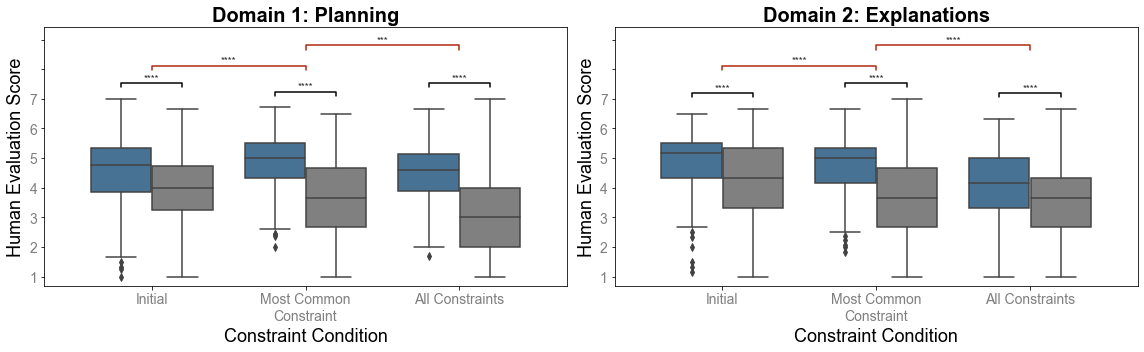

In [7]:
# stat annotation help from: https://github.com/trevismd/statannotations

from statannotations.Annotator import Annotator
import statsmodels


fig, axes = plt.subplots(1, 2, figsize=(16,5))

sns.set_style(style="dark")


x = 'Number of Constraints'
y = "Rating"
hue = 'Subject ID'


pairs_q3 = [('unconstrained', 'constrained_single'),
                ('constrained_single', 'constrained_many')]

pairs_q1 = [(('unconstrained', 'Human'), ('unconstrained', 'LLM')),
           (('constrained_single', 'Human'), ('constrained_single', 'LLM')),
           (('constrained_many', 'Human'), ('constrained_many', 'LLM'))]

# these are pulled from our stat tests
# see associated file 
p_values = {"Planning Domain": {"q1": [2.2e-16,2.2e-16,2.2e-16], "q3": [2.2e-16,0.0007449]},
            "Explanations Domain": {"q1": [2.2e-16,2.2e-16,2.2e-16], "q3": [1.902e-06, 7.889e-09]}}

domain_titles = {"Planning Domain": "Domain 1: Planning", 
                "Explanations Domain": "Domain 2: Explanations"}

for idx, (data, domain_name) in enumerate(zip([grouped_data, grouped_data_exp], ["Planning Domain", "Explanations Domain"])):

    ax = axes[idx]
    ratings = []

    for constraint in constraints:
        for source in data:
            for generation_data in data[source][constraint]:
                row = [constraint, source_text_map[source], generation_data["mean"]]
                ratings.append(

                    row)

    plot_rating_df = pd.DataFrame(ratings, columns = ['Number of Constraints', 'Subject ID', 'Rating'])
    
    ax = sns.boxplot(x=x, y=y, hue=hue, 
                     data=plot_rating_df, palette=source_palette, ax=ax)
    ax.legend([],[], frameon=False)
    ax.set_ylabel('Human Evaluation Score',fontsize=ax_size)
    ax.set_title(domain_titles[domain_name], fontsize=title_size,fontweight="bold")
    ax.set_xlabel("Constraint Condition", fontsize=ax_size)
    ax.set_yticklabels([int(tick) for tick in ax.get_yticks()[:-1]], size = tick_size, color=tick_color)
    ax.set_xticklabels(list(constraint_text_map.values()), size = tick_size, color=tick_color)
    

    plotting_params = {'x':x, 'y':y, "hue": hue,
                       'data': plot_rating_df, 
                       'text_format':'star', 'verbose':2}
    # add annotations
    annotator = Annotator(ax, pairs_q1, **plotting_params)
    annotator.set_pvalues(p_values[domain_name]["q1"])
    annotator.configure(color="black")
    annotator.annotate()
    plotting_params = {'x':x, 'y':y,
                       'data': plot_rating_df, 
                       'text_format':'star', 'verbose':2}
    
    annotator = Annotator(ax, pairs_q3, **plotting_params)
    annotator.configure(color="#B0270A")
    annotator.set_pvalues(p_values[domain_name]["q3"])
    annotator.annotate()
plt.tight_layout()
plt.savefig(f"{save_dir}human_v_llm.pdf",dpi=400)

In [8]:
# parser-and-planner vs. LLM results

def parse_success(success_str):
    return 1 if success_str == True else 0

df = pd.read_csv("./codex/final-output.csv")

print(df.head(3))

methods = ["codex", "gpt"]
constraints = ["one", "two", "all"]

data = {}

for method in methods:
    if method == "codex": df_subset = df[df.method == "codex"]
    else: df_subset = df[df.method == "gpt"]
    
    success_data = {}
    
    for constraint in constraints:
        constraint_df = df_subset[df_subset.constraints == constraint]
        successes = [parse_success(success_str) for success_str in constraint_df.succeed]
        
        success_data[constraint] = successes
        
    data[method] = success_data

   Unnamed: 0  id  succeed constraints method gpt_prompt gpt_res
0           0   3     True         one  codex        NaN     NaN
1           1   4     True         one  codex        NaN     NaN
2           2   5     True         one  codex        NaN     NaN


<ipython-input-10-13152ac03c72>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(tick,1) for tick in ax.get_yticks()[:-1]], size = tick_size, color=tick_color)
/Users/kcollins/opt/anaconda3/lib/python3.8/site-packages/statannotations/Annotator.py:803: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

two_P+S vs. two_LLM: Custom statistical test, P_val:2.200e-16
one_P+S vs. one_LLM: Custom statistical test, P_val:2.200e-16
all_P+S vs. all_LLM: Custom statistical test, P_val:2.200e-16


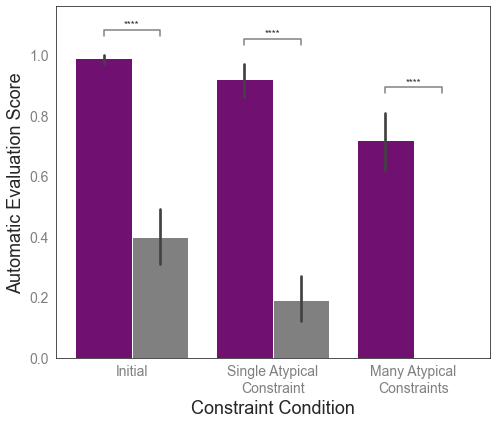

In [10]:
color_palette = ["purple", "gray"]#"red"]

constraint_text_map =  {"one": "Initial", 
                       "two": "Single Atypical\nConstraint", 
                       "all": "Many Atypical\nConstraints"}
source_text_map = {"gpt": "LLM", 
                  "codex": "P+S"}

fig, ax = plt.subplots(figsize=(7,6))
sns.set_style(style="white")

x = 'Number of Constraints'
y = 'Success Score'
hue = 'Subject ID'

pairs_q1 = [(('one', 'P+S'), ('one', 'LLM')),
           (('two', 'P+S'), ('two', 'LLM')),
           (('all', 'P+S'), ('all', 'LLM'))]

# p-values from associated R analysis 
p_values = [2.2e-16,2.2e-16,2.2e-16]

successes = []
for method in data:
    for constraint in constraints:
        for score in data[method][constraint]:
            row = [constraint, source_text_map[method], score]
            successes.append(row)
    
success_df = pd.DataFrame(successes, columns = ['Number of Constraints', 'Subject ID', 'Success Score'])

ax = sns.barplot(x=x, y=y, hue=hue, data=success_df, palette=color_palette,ax=ax)
ax.set_ylabel('Automatic Evaluation Score',fontsize=ax_size)

ax.set_xlabel("Constraint Condition", fontsize=ax_size)
ax.set_yticklabels([round(tick,1) for tick in ax.get_yticks()[:-1]], size = tick_size, color=tick_color)
ax.set_xticklabels(list(constraint_text_map.values()), size = tick_size, color=tick_color)

ax.legend([],[], frameon=False)

plotting_params = {'x':x, 'y':y, "hue": hue,
                   'data': success_df, 
                   'text_format':'star', 'verbose':2}
# add annotations
annotator = Annotator(ax, pairs_q1, **plotting_params)
annotator.set_pvalues(p_values)
annotator.configure(color="gray")
annotator.annotate()
plotting_params = {'x':x, 'y':y,
                   'data': plot_rating_df, 
                   'text_format':'star', 'verbose':2}

plt.tight_layout()
plt.savefig(f"{save_dir}parser_planner.png",dpi=400)

                                           